In [406]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS

import matplotlib.pyplot as plt 
import matplotlib 
matplotlib.rcParams.update({'font.size': 24, 'font.family': 'Helvetica', 'text.usetex': False})
%matplotlib inline

from utils.models import MLP
from utils.trainer import train_MLP
from utils.data import create_xor_dataset
from utils.plotting import plot_var

import copy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(-1.5, 1.5)

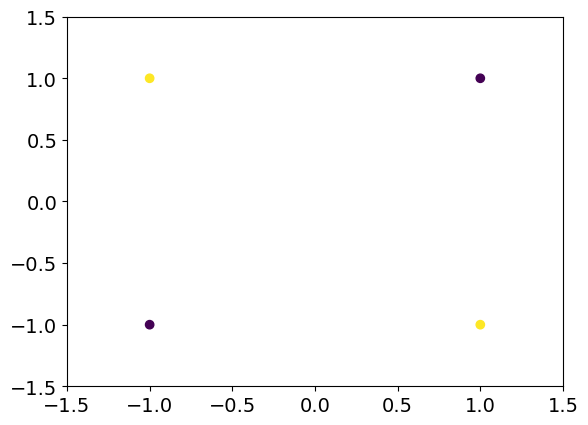

In [336]:
x1 = np.array ([-1., -1., 1., 1.], dtype = np.float32)
x2 = np.array ([-1., 1., -1., 1.], dtype = np.float32)
y_np  = np.array ([-1., 1., 1., -1.],dtype = np.float32)

X, y = create_xor_dataset(x1, x2, y_np, n_repeats=1, noise_lev=0)

plt.scatter(X[:, 0], X[:, 1], c = y)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)

In [337]:
n_runs = 1
n_epochs = 5000
dim_input = 2
dim_hidden = 500
dim_output = 1

lr = 2e-3
# Initialization scale
# w1_inits = [0.001,0.01,0.1,0.5]
w1_inits = [0.0025, 0.25]
w2_init = 1/dim_hidden

init_models = []
trained_models = []
losses = np.zeros((len(w1_inits), n_runs, n_epochs))

# Training
for w_i, w1_init in enumerate(w1_inits):
    for r_i in range(n_runs):
        # Model instantiation
        dlnn_model = MLP(dim_input, dim_hidden, dim_output, w1_init, w2_init)
        init_models.append(copy.deepcopy(dlnn_model))
    
        loss_per_run, _ = train_MLP(dlnn_model, X, y, n_epochs=n_epochs, lr=lr)
        losses[w_i, r_i, :] = loss_per_run

    trained_models.append(dlnn_model)

In [375]:
rich_models = [init_models[0], trained_models[0]]
lazy_models = [init_models[-1], trained_models[-1]]

X = torch.tensor([x1, x2]).T
y = torch.tensor(y_np).unsqueeze(1)

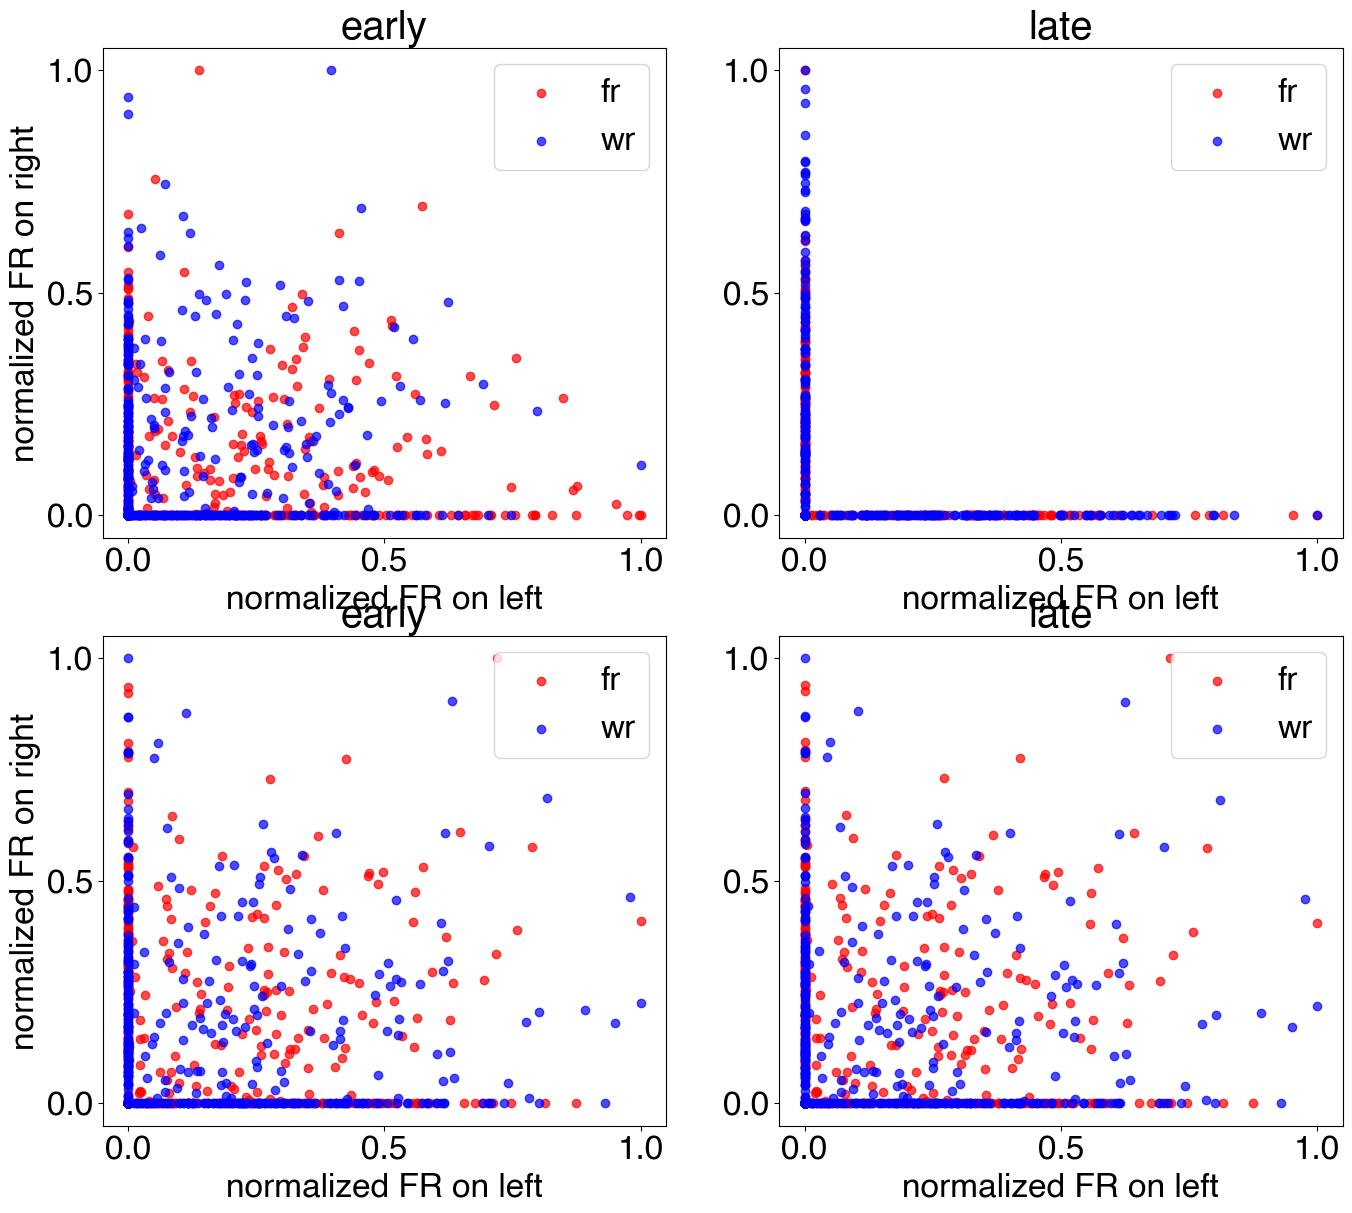

In [445]:
context_labels = ['fr', 'wr']
context_colors = ['red', 'blue']
arm_labels = ['left', 'right'] 
context_idx = [[1, 3], [0, 2]]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 14)
for m_i, model in enumerate(rich_models + lazy_models):
    axis = axes.flatten()[m_i]
    for c_i, c_label in enumerate(context_labels):
        context_X = X[context_idx[c_i]]
    
        _, hiddens = model(context_X)
        hidden_act = hiddens.detach().numpy()
        norm_act = [(act - act.min()) / (act.max() - act.min()) for act in hidden_act]
        
        axis.scatter(norm_act[0], norm_act[1], color=context_colors[c_i], alpha=0.7, label=c_label)
        axis.set_xticks([0, 0.5, 1])
        axis.set_yticks([0, 0.5, 1])
        axis.set_xlabel('normalized FR on left')
        if m_i % 2 == 0:
            axis.set_ylabel('normalized FR on right')
        axis.legend()
        
        if m_i % 2 == 0:
            axis.set_title(f'early')
        else:
            axis.set_title(f'late')
            
fig.savefig("rich_lazy_splitting.svg")

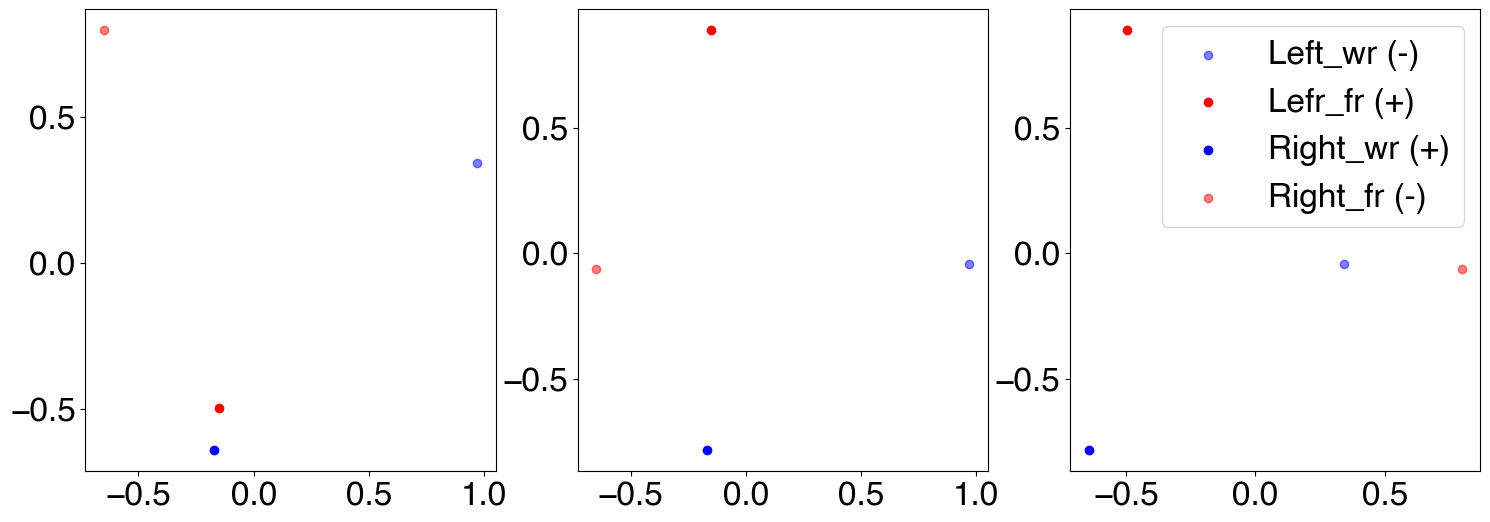

In [456]:
rich_trained_model = rich_models[-1]
_, hiddens = rich_trained_model(X)
hidden_act = hiddens.detach().numpy()

pca = make_pipeline(PCA(n_components=3))
embed_hidden = pca.fit_transform(hidden_act)

# mds = MDS(n_components=3, n_init=1, normalized_stress='auto')
# embed_hidden = mds.fit_transform(hidden_act)
# plt.scatter(embed_hidden[:, 0], embed_hidden[:, 1])

labels = ['Left_wr (-)', 'Lefr_fr (+)', 'Right_wr (+)', 'Right_fr (-)']
axes_tuples = [(0, 1), (0, 2), (1, 2)]

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18, 6)

for a_i, axis in enumerate(axes):
    x_axis, y_axis = axes_tuples[a_i]
    for l_i, label in enumerate(labels):
        color = 'blue' if l_i % 2 == 0 else 'red'
        alpha = 0.5 if l_i == 0 or l_i == 3 else 1
        axis.scatter(embed_hidden[l_i, x_axis], embed_hidden[l_i, y_axis], label=label, c=color, alpha=alpha)
plt.legend()

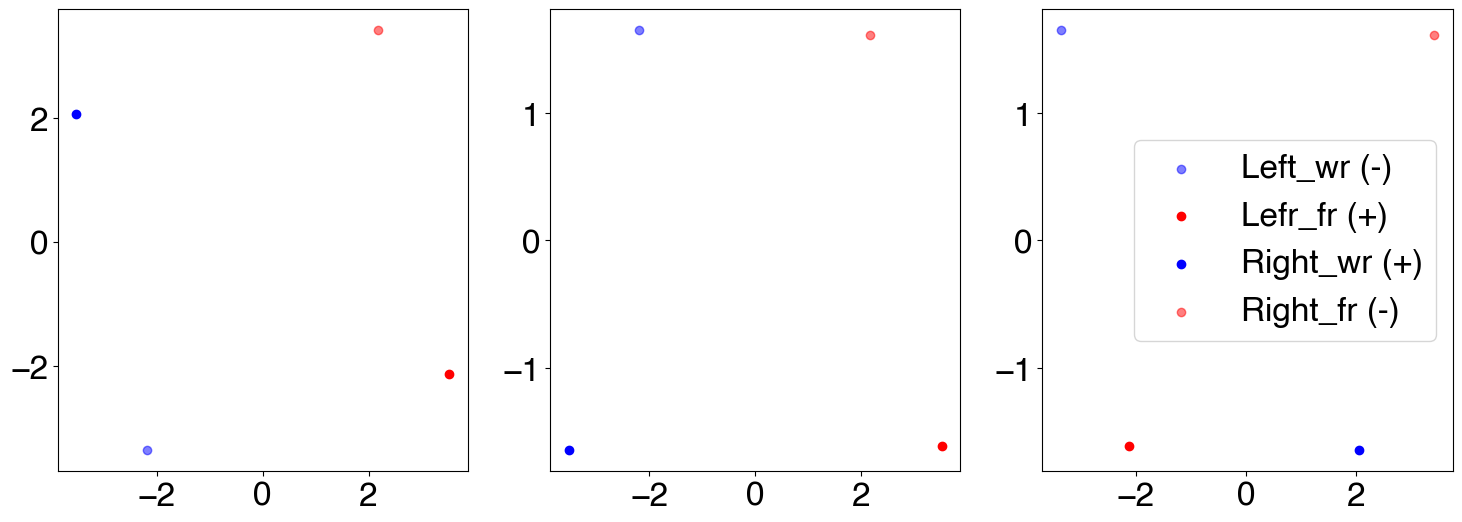

In [458]:
lazy_trained_model = lazy_models[-1]
_, hiddens = lazy_trained_model(X)
hidden_act = hiddens.detach().numpy()

pca = make_pipeline(PCA(n_components=3))
embed_hidden = pca.fit_transform(hidden_act)

# mds = MDS(n_components=3, n_init=1, normalized_stress='auto')
# embed_hidden = mds.fit_transform(hidden_act)
# plt.scatter(embed_hidden[:, 0], embed_hidden[:, 1])

labels = ['Left_wr (-)', 'Lefr_fr (+)', 'Right_wr (+)', 'Right_fr (-)']
axes_tuples = [(0, 1), (0, 2), (1, 2)]

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(18, 6)

for a_i, axis in enumerate(axes):
    x_axis, y_axis = axes_tuples[a_i]
    for l_i, label in enumerate(labels):
        color = 'blue' if l_i % 2 == 0 else 'red'
        alpha = 0.5 if l_i == 0 or l_i == 3 else 1
        axis.scatter(embed_hidden[l_i, x_axis], embed_hidden[l_i, y_axis], label=label, c=color, alpha=alpha)
plt.legend()